# Intro to simple text classification in keras

In [1]:
# Do our imports
import numpy as np
import tensorflow as tf
from keras.models import Sequential #base keras model
from keras.layers import Dense, Activation #dense = fully connected layer
from tensorflow.keras.optimizers.legacy import SGD #this is just tensorflow.keras.optimizers on earlier versions of tf

Note: The following cell will give you an error like "No module named 'matplotlib'" if you have not yet installed matplotlib or sklearn. To install it, open up a terminal/command window, activate your environment (e.g., `conda activate coding3`), and then type `conda install matplotlib` and `conda install scikit-learn`

You may have to restart the kernel if the cell does not complete running after you install.

Note that you will only ever have to do this once per environment (e.g., from now on, when you run a new notebook that imports from matplotlib using this same environment, it will also be able to use that library; no need to install again)

In [2]:
#if any of these give you problems, make sure you've installed all libraries used (pandas, sklearn, and matplot lib)
# using conda install or pip install
# see the moodle page "Instructions for setting up and using Python and Jupyter" for more info on how to do this
import pandas as pd
import matplotlib
from sklearn.feature_extraction import _stop_words
from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
!pip install -U scikit-learn

## Loading a dataset

We're going to use a small set of 1000 movie reviews from IMDB. [The original dataset can be found here.](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download) 

Here's how to load in the dataset into the notebook:

In [4]:
# This assumes the IMDBsubset.csv file lives in a directory called "data" which lives in the same directory as this notebook.
# ***if you want to edit this notebook to use a different dataset, edit this to specify a different file:
df = pd.read_csv("BTS.csv")

Now we've got the data read in! We've used a special data type called a "data frame", using the Pandas library, to store this data. Pandas makes working with data pretty convenient.

Printing df will show you the data in a table-like format (specifically, it'll show you the first and last few rows of the table).

**Note that a sentiment of "1" means "positive" and "0" means "negative"**

In [6]:
df

,query,url,title,upload_date,channel,views,likes,dislikes,comment_count,comment_text,comment_author,comment_date,comment_likes
0,bts,https://www.youtube.com/watch?v=S8GpX3SAeig,5 Hour BTS Piano Playlist | Study & Relax with...,2021-01-01T10:58:00Z,DooPiano,2444982,119269,501,3224,♪ Listen on Spotify!: https://spoti.fi/3gC9GfA...,DooPiano,2021-01-01T10:58:20Z,3884
1,bts,https://www.youtube.com/watch?v=S8GpX3SAeig,5 Hour BTS Piano Playlist | Study & Relax with...,2021-01-01T10:58:00Z,DooPiano,2444982,119269,501,3224,My ears: *relaxing* My hands: *writing* My le...,•ɱĭss süğą•,2021-01-29T15:42:43Z,4077
2,bts,https://www.youtube.com/watch?v=S8GpX3SAeig,5 Hour BTS Piano Playlist | Study & Relax with...,2021-01-01T10:58:00Z,DooPiano,2444982,119269,501,3224,Parents: You have to make us proud Partner: Y...,Leian Xyrielle Dayahan,2021-03-09T00:52:35Z,827
3,bts,https://www.youtube.com/watch?v=S8GpX3SAeig,5 Hour BTS Piano Playlist | Study & Relax with...,2021-01-01T10:58:00Z,DooPiano,2444982,119269,501,3224,Little boy: “Are you an angel?” Girl: “What?”...,Lisha,2021-02-12T15:48:08Z,921
4,bts,https://www.youtube.com/watch?v=S8GpX3SAeig,5 Hour BTS Piano Playlist | Study & Relax with...,2021-01-01T10:58:00Z,DooPiano,2444982,119269,501,3224,Reasons to live: “Suicide doesn’t stop the ...,Grace Cho,2021-02-02T18:39:00Z,2248
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28286,bts,https://www.youtube.com/watch?v=8Wq7Ip5s_Y8,BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1)...,2021-01-30T12:30:00Z,Rushi SS,62,17,0,0,Kdkk,Rahul Dongare,2021-01-31T18:48:01Z,0
28287,bts,https://www.youtube.com/watch?v=8Wq7Ip5s_Y8,BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1)...,2021-01-30T12:30:00Z,Rushi SS,62,17,0,0,Dusra part kadhi yetoy 🙄,gaurav chavan,2021-01-31T09:41:49Z,1
28288,bts,https://www.youtube.com/watch?v=8Wq7Ip5s_Y8,BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1)...,2021-01-30T12:30:00Z,Rushi SS,62,17,0,0,😁😁😂😂😂,Premkumar Ghodake,2021-01-30T12:38:34Z,1
28289,bts,https://www.youtube.com/watch?v=8Wq7Ip5s_Y8,BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1)...,2021-01-30T12:30:00Z,Rushi SS,62,17,0,0,Kay tha bhai ye 🤔🤔🤔 but achhha tha 👍🐱🐱🐱😁,Komal Jagtap,2021-01-30T15:20:56Z,2


This is great, but if we want to read the full reviews (handy for later) then we can change our display options:

In [7]:
pd.set_option('display.max_colwidth', None) #show me everything in the column, even if it's long!
df #Show me the first and last few examples

query                                          url   
0       bts  https://www.youtube.com/watch?v=S8GpX3SAeig  \
1       bts  https://www.youtube.com/watch?v=S8GpX3SAeig   
2       bts  https://www.youtube.com/watch?v=S8GpX3SAeig   
3       bts  https://www.youtube.com/watch?v=S8GpX3SAeig   
4       bts  https://www.youtube.com/watch?v=S8GpX3SAeig   
...     ...                                          ...   
28286   bts  https://www.youtube.com/watch?v=8Wq7Ip5s_Y8   
28287   bts  https://www.youtube.com/watch?v=8Wq7Ip5s_Y8   
28288   bts  https://www.youtube.com/watch?v=8Wq7Ip5s_Y8   
28289   bts  https://www.youtube.com/watch?v=8Wq7Ip5s_Y8   
28290   bts  https://www.youtube.com/watch?v=8Wq7Ip5s_Y8   

                                                           title   
0             5 Hour BTS Piano Playlist | Study & Relax with BTS  \
1             5 Hour BTS Piano Playlist | Study & Relax with BTS   
2             5 Hour BTS Piano Playlist | Study & Relax with BTS   
3             5 Hour BTS Piano Playlist | Study & Relax with BTS   
4             5 Hour BTS Piano Playlist | Study & Relax with BTS   
...                                                          ...   
28286  BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1) | Rushi SS   
28287  BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1) | Rushi SS   
28288  BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1) | Rushi SS   
28289  BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1) | Rushi SS   
28290  BTS OF BHAI KI JOURNEY | INTRODUCTION (PART 1) | Rushi SS   

                upload_date   channel    views   likes  dislikes   
0      2021-01-01T10:58:00Z  DooPiano  2444982  119269       501  \
1      2021-01-01T10:58:00Z  DooPiano  2444982  119269       501   
2      2021-01-01T10:58:00Z  DooPiano  2444982  119269       501   
3      2021-01-01T10:58:00Z  DooPiano  2444982  119269       501   
4      2021-01-01T10:58:00Z  DooPiano  2444982  119269       501   
...                     ...       ...      ...     ...       ...   
28286  2021-01-30T12:30:00Z  Rushi SS       62      17         0   
28287  2021-01-30T12:30:00Z  Rushi SS       62      17         0   
28288  2021-01-30T12:30:00Z  Rushi SS       62      17         0   
28289  2021-01-30T12:30:00Z  Rushi SS       62      17         0   
28290  2021-01-30T12:30:00Z  Rushi SS       62      17         0   

       comment_count   
0               3224  \
1               3224   
2               3224   
3               3224   
4               3224   
...              ...   
28286              0   
28287              0   
28288              0   
28289              0   
28290              0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Let's do something super simple to transform this into a dataset that we can send to a neural network. 

Similarly to the sentiment classification we discussed in lecture last week, we're going to represent each example (review) as a vector of word counts.

The CountVectorizer object from sklearn allows us to make these word count vectors pretty easily. Once we do the counts, we'll store these in a new dataframe.


The following code transforms a review dataframe to a word count dataframe called wordcounts.

In [9]:
# Transform a dataframe containing a column named "review" 
# such that each row becomes represented by a set of word counts, corresponding to the number of each term in the review

#These next two lines perform word counting:
vectorizer = CountVectorizer(stop_words='english', min_df=0.01)
#stop_words='english' removes very common english words that are unlikely to be useful (e.g. "and", "the")
#min_df=0.1 removes very rare words that are likely to be typos, uninformative, etc.
# You can type ?CountVectorizer in its own cell to read its documentation
#***Note that "df['review']" is used below because "review" is the name of the column containing our text in the dataframe
#If you apply this to your own data, you may probably need to change this column name!
matrix = vectorizer.fit_transform(df['comment_text'])
    
#This line converts matrix into another dataframe, with column names corresponding to the word being counted
data = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())

Take a look at the data:

In [13]:
data #prints data to screen

,amazing,army,armys,baby,beautiful,best,bts,cute,dance,day,...,video,voice,want,watch,watching,way,world,wow,yo,yoongi
0,0,0,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,2,2,2,0,1,6,...,0,0,2,0,1,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Note that you can examine this dataset, e.g. to look at the column of counts for the word "wonderful":

In [14]:
data["amazing"]

0        0
1        0
2        0
3        0
4        1
        ..
28286    0
28287    0
28288    0
28289    0
28290    0
Name: amazing, Length: 28291, dtype: int64

In [15]:
#or the word hate:
data["best"]

0        1
1        0
2        0
3        0
4        2
        ..
28286    0
28287    0
28288    0
28289    0
28290    0
Name: best, Length: 28291, dtype: int64

## Let's do some machine learning!

In [39]:
#First, let's split our dataset into training and test sets
# Remember: X is for input, y is for output
# The first argument of train_test_split is your training data (here, lives in "data" object you created using word counts)
# The second argument of train_test_split is your labels/targets for the training data. This lives in the "sentiment" column of the original dataframe df we loaded from the file.
# (***If you are using a different dataset, you'll need to change the name of this column to whatever it is in your dataset)
# The test_size argument specifies % of data going into test set: here, 20% of the data goes into test set and 80% goes into training set
X_train, X_test, y_train, y_test = train_test_split(data, df['comment_likes'], test_size=0.2, random_state=0)

In [40]:
#If you ever want to learn more about a function, you can always use ? 
?train_test_split

In [41]:
# We can examine it a bit using np.shape:
np.shape(X_train) #What does our training data look like? It's 800 rows, with 1674 dimensions of input (features)

(22632, 84)

In [42]:
#Now let's make a simple neural network with 1 hidden layer containing 10 neurons
num_neurons = 10 # neurons in each layer
model = Sequential()

#Make the first (hidden) layer, which will have num_neurons neurons. Each neuron will get inputs from all columns of the dataframe, except sentiment
#model.add(Dense(num_neurons, input_dim=len(data.columns)-1))
model.add(Dense(num_neurons, input_dim=np.shape(X_train)[1]))
model.add(Activation('sigmoid')) #Now we'll use a sigmoid activation function

#Now let's add another layer for the output: A single sigmoid neuron.
model.add(Dense(1)) 
model.add(Activation('sigmoid'))

In [43]:
#Use compile() to set up our training

# For loss, we'll use binary cross-entropy loss, 
# which is appropriate for a binary classification problem (0/1 for negative/positive)
# ***If you edit this notebook to apply it to a multi-class classification problem, you'll need 
#    to change the loss to something like categorical_crossentropy, and you'll also need to change the
#    encoding of the class to a one hot representation (see https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)


model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
#Train it!
# Plus store history of training in a variable called "history"
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
708/708 [==============================] - 1s 2ms/step - loss: -693191.2500 - accuracy: 0.1563 - val_loss: -1104093.6250 - val_accuracy: 0.1488
Epoch 2/10
708/708 [==============================] - 1s 1ms/step - loss: -2099040.0000 - accuracy: 0.1561 - val_loss: -2211628.5000 - val_accuracy: 0.1488
Epoch 3/10
708/708 [==============================] - 1s 1ms/step - loss: -3503177.0000 - accuracy: 0.1561 - val_loss: -3320042.2500 - val_accuracy: 0.1488
Epoch 4/10
708/708 [==============================] - 1s 1ms/step - loss: -4909076.5000 - accuracy: 0.1561 - val_loss: -4428100.5000 - val_accuracy: 0.1488
Epoch 5/10
708/708 [==============================] - 1s 1ms/step - loss: -6314167.0000 - accuracy: 0.1561 - val_loss: -5536713.0000 - val_accuracy: 0.1488
Epoch 6/10
708/708 [==============================] - 1s 1ms/step - loss: -7719833.5000 - accuracy: 0.1561 - val_loss: -6644158.0000 - val_accuracy: 0.1488
Epoch 7/10
708/708 [==============================] - 1s 1ms/step

Let's take a look at how training set and test set accuracy change with each epoch:

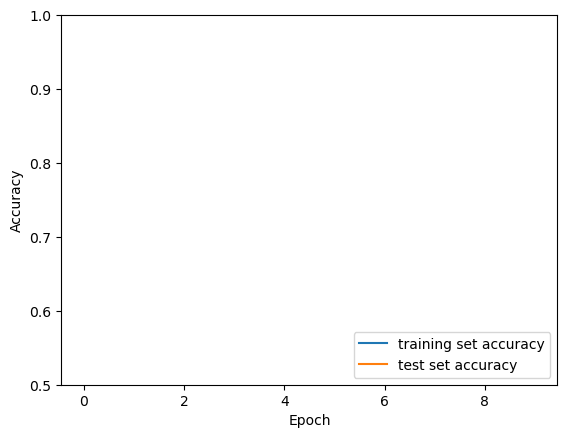

In [45]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

## Examining model behaviour

First, let's explore how we can apply the trained model to a specific example in our test data (or training data), to examine what it's done.

We'll use the following code techniques:
* We can apply the trained model to any example using the `.predict()` function
* We can get the nth row from any dataframe using the `.iloc[[n]]` function

In [46]:
#For instance, let's make z the first test example:
z = X_test.iloc[[0]]

#and let's output the prediction for this example:
model.predict(z)

1/1 [==============================] - 0s 48ms/step


array([[1.]], dtype=float32)

Note that this prediction will be somewhere between 0 and 1. This can be interpreted loosely as confidence: closer to 1 is more confident it is positive sentiment, closer to 0 is more confident it is negative sentiment.

Let's compare this to the actual sentiment of the review, as stored in y_test:

In [47]:
y_test.iloc[[0]]

13606    18
Name: comment_likes, dtype: int64

To make sense of this, we probably also want to look at the actual text review, which doesn't live in X_test but does live in the original dataframe we loaded from the CSV file, i.e. `df`. Since our `train_test_split` function has randomised the order of the data before splitting into training and testing sets, we need to get the id (row number) for `df` corresponding to this first test example.

In [48]:
test_ids = list(X_test.index) #gets the original indices in the df dataframe
#test_ids[n] now refers to the id number of the nth test example
originalReview = df.iloc[[test_ids[0]]].views
originalReview

13606    307744
Name: views, dtype: int64

Try this with a few more examples and see what you find. If you're comfortable with python, can you think of a way to identify misclassified test examples and just print out those? Or, even better, find test examples that are confidently classified correctly, or test examples that are "confidently" misclassified, and examine those?

For more fun, how about testing this classifier on our own new, fake "reviews"? Here's code to create an example of your own and apply the classifier to it. We'll have to first convert a string of text to a vector of word counts and put it in a dataframe, so here's a function for that:

In [49]:
# Turns a text string into a dataframe example (***Note you'll need to change this from 'review' for your own dataset)
def createExample(myText):

    newExample = np.array([[myText]])
    tdf = pd.DataFrame(newExample, columns=["views"])
    matrix = vectorizer.transform(tdf['views'])
    newDf = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return newDf 

In [50]:
#Here's a text about zombies
myText = "This movie is about zombies zombies zombies"
t = createExample(myText) #When we print the dataframe, you see zombies' word count is 3:
t

,amazing,army,armys,baby,beautiful,best,bts,cute,dance,day,...,video,voice,want,watch,watching,way,world,wow,yo,yoongi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
#apply the model to classify your new text:
model.predict(t)

1/1 [==============================] - 0s 30ms/step


array([[1.]], dtype=float32)

Now try writing some "great" and "terrible" reviews and see what happens to the classification outputs:

In [52]:
model.predict(createExample("This movie is the worst it's terrible horrible"))

1/1 [==============================] - 0s 23ms/step


array([[1.]], dtype=float32)

## Explore on your own

Change the code above to explore:
* Does changing the number of neurons in the hidden layer change the results? What happens to accuracy when you use 1 neuron? 100 neurons? 
* Try editing the neural network so that you have 2 hidden layers of 10 neurons each. What happens to accuracy? 

Investigating the model
* Can you examine the model's performance on the test data to discover anything about what mistakes this model makes? Or anything about what types of reviews are easy to classify accurately?
* Can you come up with your own, new examples of positive or negative reviews that illustrate the mistakes the model makes?